# Introduction to Brevitas - Quantization Aware Training 

Brevitas library allows so called quantization aware training.

That means at the time of training we assume that our model's (network's) destination inference is implemented in lower precision.

We know quantization change inference results.

We can prevent it by appropriate model training, which includes quantization operation "simulation" - our computations are still on floating points.


For this laboratory we will use mentioned brevitas library.

You can install it by running following cell.

In [2]:
%pip install brevitas==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 KB 12.2 MB/s eta 0:00:00


In [3]:
!mkdir data

In [5]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

# local_utils file contains util functions for training or display
# CHECK IT
import local_utils as lu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


Datasets

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

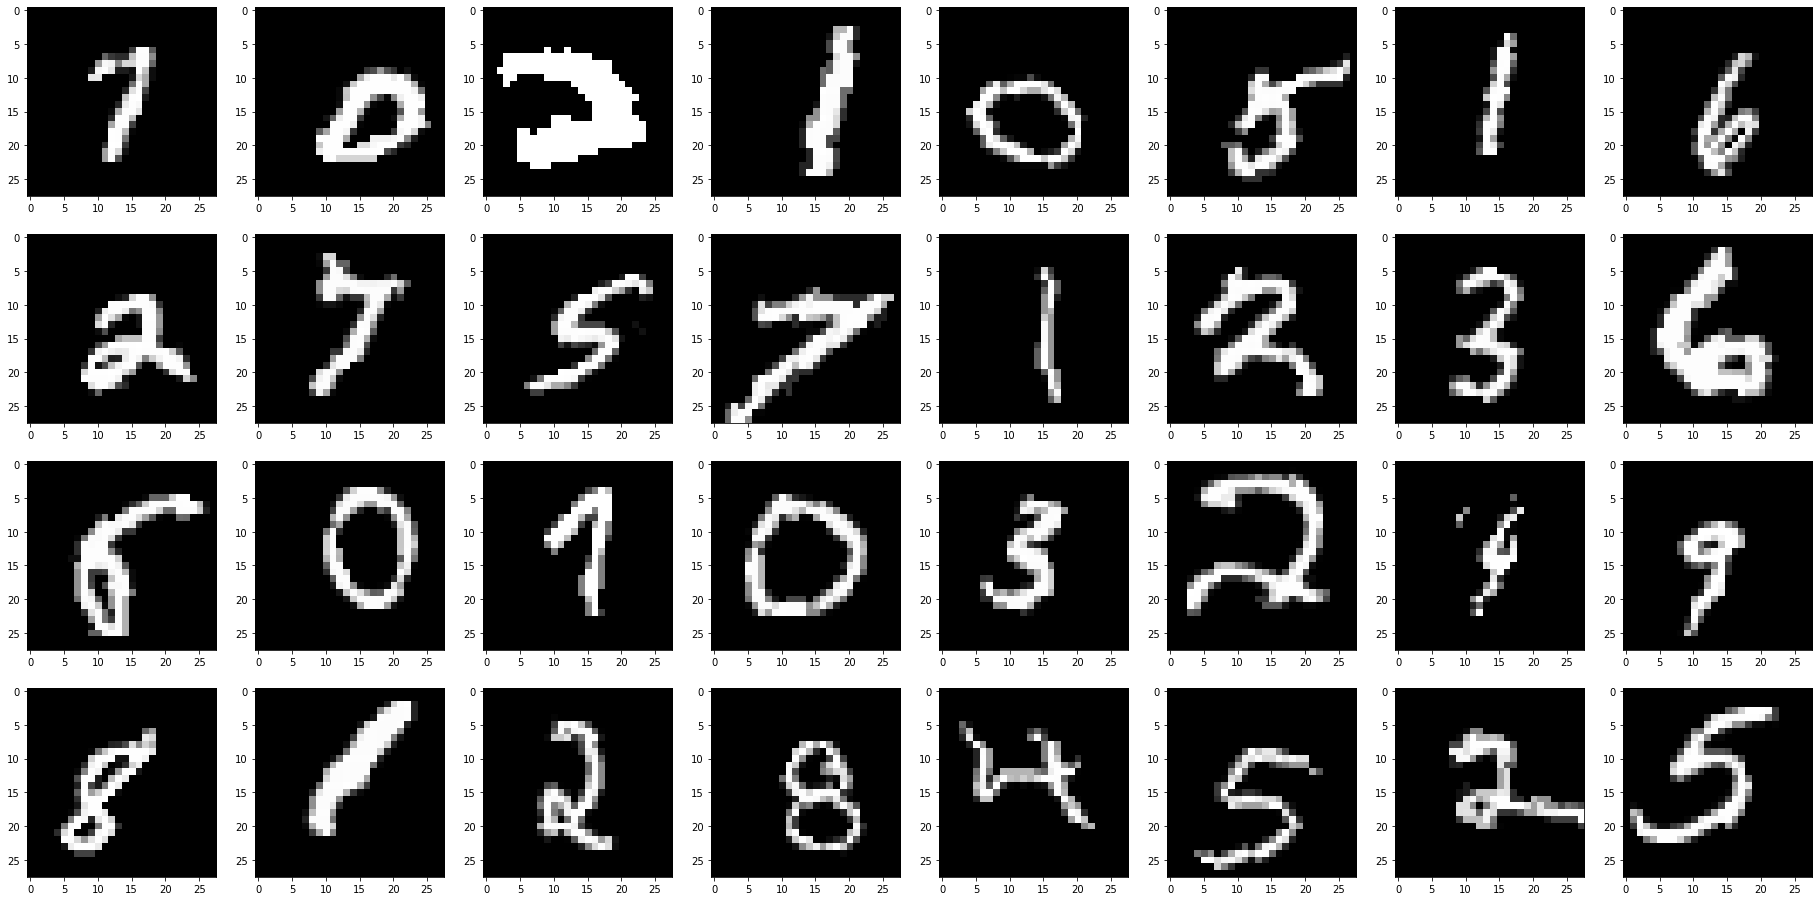

In [6]:
from torchvision.transforms import ToTensor, Compose, RandomAffine  # RandomEqualize, 
from torchvision.transforms import RandomRotation

transforms = Compose([
                    RandomAffine(10, (0.1,0.1), (0.8, 1.2)),
                    RandomRotation(5),
                    # RandomEqualize(),
                    ToTensor(),
                    ])

BATCH_SIZE = 64

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=transforms)
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 4, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.squeeze())
    plt.show()
            
    break
        

1. Brevitas - QuantIdentity

Layer takes arguments:
- quantizer - appropriate object from brvitas library which implements proper quantization method for data type - activation 

    Here is used `Int8ActPerTensorFloatMinMaxInit` - signed fixed point quantization 
- quantizer's arguments: 
    - for used quantizer these are: `min_val` and `max_val`, 
    
    but for quantization is used only maximal absolute value of both.
    
    `bit_width` is also possible to change from default 8 bit. 
    
- `return_quant_tensor` - when to return or not QuantTensor - float tensor with quantization description.

Your task is to explore quantization for all possible fixed point precisions for mentioned quantizer.

How many different precisions exist for this quantizer?

Note: brevitas allows for max_val/min_val to different than power of 2, but here use only power of 2.


In [7]:
from brevitas.nn import QuantIdentity
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit

inp = (torch.rand(1, 1, 4, 5, requires_grad=False) - 0.5) * 20
print("INPUT TENSOR = ",[e*10**4//1 / 10**4 for e in inp.flatten().tolist()])

for i in range(len(inp)):
    max_val = torch.max(inp)

    print(f"MAX_VAL = {i+1}")
    print(f"INTEGER BITS = {i+1}")
    identity = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, 
                             min_val=-max_val, 
                             max_val=max_val, 
                             bit_width=8,
                             return_quant_tensor=True)
    identity.train(False)

    # Process by quant identity
    t, scale, zp, bw, is_signed, is_from_training_mode = identity(inp)
    
    precision_bits = -torch.log2(scale).round().to(torch.int).item()
    print("Result tensor = ", t.flatten().tolist())
    print("Scale = ", scale.item())
    print("Precision Bits = ", precision_bits)
    print("Bit width = ", bw.to(torch.int).item())


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INPUT TENSOR =  [4.8389, 0.4622, -7.3032, -3.8233, -2.0917, -9.6834, -5.3006, 2.7721, 1.4066, -7.8249, -1.1125, 7.5436, -9.7211, -0.1896, 7.4038, 7.502, -0.1797, 5.5426, -9.3691, -7.5776]
MAX_VAL = 1
INTEGER BITS = 1
Result tensor =  [4.832677841186523, 0.4714807868003845, -7.307952404022217, -3.8307814598083496, -2.0627284049987793, -7.543692588806152, -5.304158687591553, 2.7699496746063232, 1.4144423007965088, -7.543692588806152, -1.1197668313980103, 7.484757423400879, -7.543692588806152, -0.1768052875995636, 7.4258222579956055, 7.484757423400879, -0.1768052875995636, 5.5398993492126465, -7.543692588806152, -7.543692588806152]
Scale =  0.058935098350048065
Precision Bits =  4
Bit width =  8


2. QuantConv2d
For quantization of convolution there is needed also weights and bias quantization.

`QuantConv2d` module is a subclass of `torch.nn.Conv2d` and all it's arguments are also available.

Additional arguments:
- `input_quant` - input quantization - it's not necessary to use it, if input is quantized before the layer
- `output_quant` - output quantization - it's not necessary to use it, if output is quantized after the layer,
- `weight_quant` - quantization of convolution weights. Here is used quantizer:

    `Int8WeightPerTensorFloat` - allows for signed fixed point quantization with maximal precision,

- `bias_quant`   - quantization of convolution bias. Here is used quantizer:

    `Int8BiasPerTensorFloatInternalScaling` - allows for signed quantization with scale set internally by 
    
    analysis of weights' quantization,

- `return_quant_tensor` - when to return or not QuantTensor - float tensor with quantization description.

- layer takes also quantizers' parameters with proper prefix f.e. for weight quantizer parameter bit_width is named `weight_bit_widths` 

Your task:

Print weight and bias non-quantized - raw floating point tensors.

Next use methods `quant_weight` and `quant_bias` to obtain their quantized versions. 

For QuantTensors `[input_tq, conv_tq, output_tq]` and quantized tensors of weight and bias: 

print number of theirs' precision bits, bit widths, scale and result tensor, 

Note the number of bits at each level of processing.

In [8]:
from brevitas.nn import QuantConv2d
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit, \
    Int8WeightPerTensorFloat, Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


conv_layer = QuantConv2d(1,1,3,padding=1,bias=True, 
                         weight_quant=Int8WeightPerTensorFloat,
                         weight_bit_width=8,
                         bias_quant=Int8BiasPerTensorFloatInternalScaling,
                         return_quant_tensor=True
                         )
input_layer = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, min_val=-1.0, max_val=1.0, return_quant_tensor=True)
output_layer = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, min_val=-4.0, max_val=4.0, return_quant_tensor=True)

input_tensor = torch.rand(1,1,3,3)

input_tq = input_layer(input_tensor)
conv_tq = conv_layer(input_tq)
output_tq = output_layer(conv_tq)

print("Result tensor = ", input_tq)
print("Bit width = ",input_tq.bit_width)
print("Scale = ", input_tq.scale)
print("Precision Bits = ", -torch.log2(input_tq.scale).round().to(torch.int).item())

print("Result tensor = ", conv_tq)
print("Bit width = ",conv_tq.bit_width)
print("Scale = ", conv_tq.scale)
print("Precision Bits = ", -torch.log2(conv_tq.scale).round().to(torch.int).item())

print("Result tensor = ", input_tq)
print("Bit width = ",output_tq.bit_width)
print("Scale = ", output_tq.scale)
print("Precision Bits = ", -torch.log2(output_tq.scale).round().to(torch.int).item())


weight_tq = conv_layer.quant_weight()
bias_tq = conv_layer.quant_bias()

Result tensor =  QuantTensor(value=tensor([[[[0.3984, 0.7344, 0.2344],
          [0.0156, 0.5625, 0.6094],
          [0.3125, 0.1016, 0.8750]]]], grad_fn=<MulBackward0>), scale=tensor(0.0078, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True))
Bit width =  tensor(8.)
Scale =  tensor(0.0078, grad_fn=<DivBackward0>)
Precision Bits =  7
Result tensor =  QuantTensor(value=tensor([[[[0.0804, 0.5487, 0.4404],
          [0.0868, 0.4087, 0.6793],
          [0.0451, 0.0055, 0.3128]]]], grad_fn=<ConvolutionBackward0>), scale=tensor([[[[2.0424e-05]]]], grad_fn=<MulBackward0>), zero_point=tensor([[[[155.0660]]]], grad_fn=<DivBackward0>), bit_width=tensor(21.), signed_t=tensor(True), training_t=tensor(True))
Bit width =  tensor(21.)
Scale =  tensor([[[[2.0424e-05]]]], grad_fn=<MulBackward0>)
Precision Bits =  16
Result tensor =  QuantTensor(value=tensor([[[[0.3984, 0.7344, 0.2344],
          [0.0156, 0.5625, 0.6094],
          [0.312

3. Floating point Network quantization allows to obtain so called Quantized Neural Network.

Both networks have the same topology, but QNN has additional nonlinearities - quantization.

Your tasks:

- Create two models of `NeuralNetwork`:
    - floating point model 
    - quantized model

- print parameters names and theirs shapes for both models. 
    
    Are there any differences ?
    

In [16]:
from brevitas.nn import QuantConv2d, QuantIdentity
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit, \
    Int8WeightPerTensorFloat, Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28), 
                 num_of_classes=10,
                 quantize=True
                 ) -> None:
        super().__init__()
        channels = [input_shape[0],16,32,64,128]
        padding = [1,1,0,0]
        max_pool = [1,1,0,0]
         
        if quantize:
            input_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0)
        else:
            input_quant = QuantIdentity(None)
        
        layers = []
        for i, (ch_in, ch_out, p, mp) in enumerate(zip(channels[:-1],
                                                       channels[1:],
                                                       padding,
                                                       max_pool)):
            conv = QuantConv2d(ch_in, ch_out, 3, padding=p, bias=True, 
                               weight_quant=Int8WeightPerTensorFloat if quantize else None,
                               bias_quant=Int8BiasPerTensorFloatInternalScaling if quantize else None,
                               return_quant_tensor=False
                               )
            layers.append(conv)
            
            if quantize:
                out_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0)
            else:
                out_quant = QuantIdentity(None)
            
            layers.append(out_quant)
            relu = nn.ReLU()
            layers.append(relu)
            
            if mp:
                maxpool = nn.MaxPool2d(2,2)
                layers.append(maxpool)
        
        self.CNN = nn.Sequential(input_quant, *tuple(layers))
        
        CNN_out_shape = [
                         channels[-1],
                         input_shape[-2]//2//2 - 3//2*2 - 3//2*2,
                         input_shape[-1]//2//2 - 3//2*2 - 3//2*2
                        ]
        CNN_flatten_len = torch.prod(torch.tensor(CNN_out_shape))
        print(f"CNN out shape = {CNN_out_shape}")
        print(f"CNN numel = {CNN_flatten_len}")
        print(f"CNN parameters:{net.parameters}")
        print("----------------------------------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------------------------------")

        self.FC = nn.Sequential(
                               nn.Flatten(),
                               nn.Linear(CNN_flatten_len, num_of_classes),
                               nn.Softmax(1),
                               )
    
    def forward(self, x: torch.Tensor):
        return self.FC(self.CNN(x))
        
        
net = NeuralNetwork(quantize=False)
qnet = NeuralNetwork(quantize=True)

CNN out shape = [128, 3, 3]
CNN numel = 1152
CNN parameters:<bound method Module.parameters of NeuralNetwork(
  (CNN): Sequential(
    (0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
    )
    (1): QuantConv2d(
      1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (bias_quant): BiasQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
    )
    (2): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )


4. Train floating model:
- for 8 epochs, 
- `SGD` optimizer,
- learning rate = 0.01,
- momentum = 0.6,
- weight_decay = 1e-6 - penalty for weights values
- update period of 5 batches
- cross entropy loss
- accuracy metric


Hint. `local_utils`

In [ ]:
import local_utils

history = local_utils.training(model=net,
train_loader=train_loader,
test_loader=test_loader,
loss_fcn=nn.CrossEntropyLoss(),
metric=local_utils.AccuracyMetic(),
optimizer=torch.optim.SGD(params=net.parameters(),lr=0.01,momentum=0.6),
update_period = 5,
epoch_max = 8,
device=device
)



Epoch 1 / 8: STARTED
TRAINING

938it [01:04, 14.58it/s]


VALIDATION

157it [00:08, 17.55it/s]


After epoch 1: loss=2.3023 acc=0.1074 val_loss=2.3015 val_acc=0.1301
Epoch 1 / 8: FINISHED

Epoch 2 / 8: STARTED
TRAINING

938it [01:01, 15.25it/s]


VALIDATION

157it [00:08, 18.72it/s]


After epoch 2: loss=2.3009 acc=0.1834 val_loss=2.2982 val_acc=0.2457
Epoch 2 / 8: FINISHED

Epoch 3 / 8: STARTED
TRAINING

938it [01:02, 15.11it/s]


VALIDATION

157it [00:08, 18.87it/s]


After epoch 3: loss=2.2708 acc=0.1920 val_loss=1.9976 val_acc=0.5182
Epoch 3 / 8: FINISHED

Epoch 4 / 8: STARTED
TRAINING

938it [01:02, 14.92it/s]


VALIDATION

157it [00:08, 18.32it/s]


After epoch 4: loss=1.9465 acc=0.5234 val_loss=1.7436 val_acc=0.7238
Epoch 4 / 8: FINISHED

Epoch 5 / 8: STARTED
TRAINING

938it [01:00, 15.47it/s]


VALIDATION

157it [00:08, 19.39it/s]


After epoch 5: loss=1.8097 acc=0.6607 val_loss=1.6538 val_acc=0.8156
Epoch 5 / 8: FINISHED

Epoch 6 / 8: STARTED
TRAINING

938it [01:01, 15.17it/s]


VALIDATION

157it [00:08, 18.91it/s]


After epoch 6: loss=1.7172 acc=0.7531 val_loss=1.6420 val_acc=0.8260
Epoch 6 / 8: FINISHED

Epoch 7 / 8: STARTED
TRAINING

938it [01:01, 15.28it/s]


VALIDATION

157it [00:08, 19.06it/s]


After epoch 7: loss=1.6798 acc=0.7861 val_loss=1.6047 val_acc=0.8591
Epoch 7 / 8: FINISHED

Epoch 8 / 8: STARTED
TRAINING

938it [01:00, 15.41it/s]


VALIDATION

157it [00:08, 19.05it/s]

After epoch 8: loss=1.6567 acc=0.8092 val_loss=1.5971 val_acc=0.8667
Epoch 8 / 8: FINISHED



5. Display history and print validation/test loss and accuracy for last epoch. 

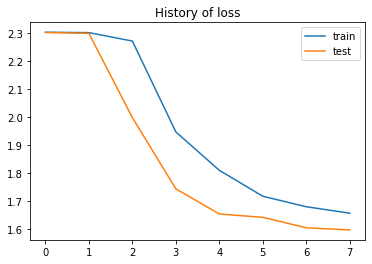

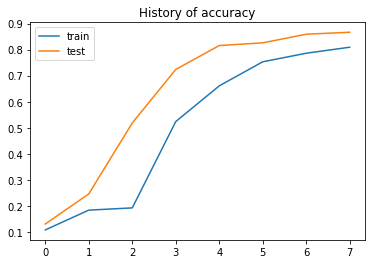

In [ ]:
local_utils.plot_history(history[1])

6. Extract state dict from trained floating point model.

Load it into quantized model (`load_state_dict` method). 

In [ ]:
torch.save(net.state_dict(),"floatModel.pth")
qnet.load_state_dict(torch.load("floatModel.pth"),strict=False)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1428: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


_IncompatibleKeys(missing_keys=['CNN.0.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value', 'CNN.2.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value', 'CNN.6.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value', 'CNN.10.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value', 'CNN.13.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value'], unexpected_keys=[])

7. Calculate validation loss and metric for quantized model. 

8. Train quantized model with the same parameters as floating point model.


In [ ]:
import local_utils
history_new = local_utils.training(model=qnet,
train_loader=train_loader,
test_loader=test_loader,
loss_fcn=nn.CrossEntropyLoss(),
metric=local_utils.AccuracyMetic(),
optimizer=torch.optim.SGD(params=net.parameters(),lr=0.01,momentum=0.6),
update_period = 5,
epoch_max = 1,
device=device
)

Epoch 1 / 1: STARTED
TRAINING

938it [02:04,  7.54it/s]


VALIDATION

157it [00:17,  8.75it/s]

After epoch 1: loss=1.6453 acc=0.8204 val_loss=1.5971 val_acc=0.8669
Epoch 1 / 1: FINISHED



9. Display history of training and validation loss and metric.

Compare results with floating point model training. 

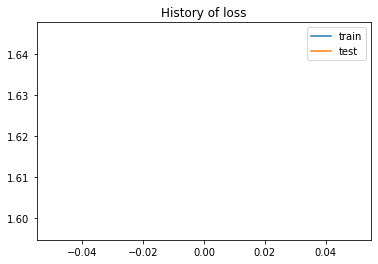

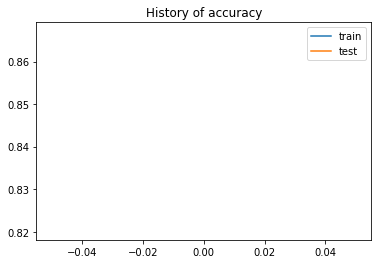

In [ ]:
local_utils.plot_history(history_new[1])

10. *Additional - Train quantized model without initialization by pretrained floating point model.

You can change training hyperparameters.

Display training history and final validation accuracy and loss.

Compare result with previously trained models of `NeuralNetwork`s' architectures.

In [ ]:
qnetNew = NeuralNetwork(quantize=True)

history3= local_utils.training(model=qnet,
train_loader=train_loader,
test_loader=test_loader,
loss_fcn=nn.CrossEntropyLoss(),
metric=local_utils.AccuracyMetic(),
optimizer=torch.optim.SGD(params=net.parameters(),lr=0.01,momentum=0.6),
update_period = 5,
epoch_max = 4,
device=device
)

local_utils.plot_history(history3[1])

CNN out shape = [128, 3, 3]
CNN numel = 1152
Epoch 1 / 4: STARTED
TRAINING

69it [00:08,  8.44it/s]

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.